# 0 - PopForecast — EDA (Cycle 1 / MVP)

This notebook performs a lightweight exploratory data analysis (EDA) to support the Cycle 1 MVP.
Goals: validate the target (`song_popularity`), understand basic data quality issues, and define a first feature set.
We will explicitly identify potential leakage/proxy columns and decide a split strategy (temporal vs random) and baseline metrics.
Engineering-heavy transformations will be implemented later in the project scripts, not in this notebook.


# 1 - Setup

## 1.1 - Imports

In [1]:
from __future__ import annotations

from pathlib import Path
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## 1.2 - Global settings

In [2]:
# --- Reproducibility (use only when sampling / splitting inside the notebook) ---
RANDOM_STATE = 42

# --- Pandas display ---
pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 120)
pd.set_option("display.max_colwidth", 60)
pd.set_option("display.float_format", "{:,.4f}".format)

# --- Matplotlib defaults (lightweight) ---
plt.rcParams["figure.figsize"] = (10, 4)
plt.rcParams["axes.grid"] = True

## 1.3 - Project paths

In [3]:
PROJECT_ROOT = Path.cwd().parent
DATA_RAW_PATH = PROJECT_ROOT / "data" / "raw" / "spotify_tracks_metadata.csv"

# 2. Data Loading

In [4]:
data_raw = pd.read_csv(DATA_RAW_PATH)
display(data_raw.head())
print(f'Raw Dataset Shape: {data_raw.shape}')

,Unnamed: 0,spotify_id,song_name,artist_name,song_popularity,album_release_date,album_release_year,album_release_month,analysis_url,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,song_explicit,speechiness,tempo,time_signature,total_available_markets,track_href,uri,valence
0,0,7lPN2DXiMsVn7XUKtOW1CS,drivers license,Olivia Rodrigo,100,2021-01-08,"2,021.0000",1.0000,https://api.spotify.com/v1/audio-analysis/7lPN2DXiMsVn7X...,0.7210,0.5850,"242,014.0000",0.4360,0.0000,10.0000,0.1050,-8.7610,1.0000,True,0.0601,143.8740,4.0000,170,https://api.spotify.com/v1/tracks/7lPN2DXiMsVn7XUKtOW1CS,spotify:track:7lPN2DXiMsVn7XUKtOW1CS,0.1320
1,1,5QO79kh1waicV47BqGRL3g,Save Your Tears,The Weeknd,96,2020-03-20,"2,020.0000",3.0000,https://api.spotify.com/v1/audio-analysis/5QO79kh1waicV4...,0.0212,0.6800,"215,627.0000",0.8260,0.0000,0.0000,0.5430,-5.4870,1.0000,True,0.0309,118.0510,4.0000,170,https://api.spotify.com/v1/tracks/5QO79kh1waicV47BqGRL3g,spotify:track:5QO79kh1waicV47BqGRL3g,0.6440
2,2,0VjIjW4GlUZAMYd2vXMi3b,Blinding Lights,The Weeknd,96,2020-03-20,"2,020.0000",3.0000,https://api.spotify.com/v1/audio-analysis/0VjIjW4GlUZAMY...,0.0015,0.5140,"200,040.0000",0.7300,0.0001,1.0000,0.0897,-5.9340,1.0000,False,0.0598,171.0050,4.0000,170,https://api.spotify.com/v1/tracks/0VjIjW4GlUZAMYd2vXMi3b,spotify:track:0VjIjW4GlUZAMYd2vXMi3b,0.3340
3,3,3tjFYV6RSFtuktYl3ZtYcq,Mood (feat. iann dior),24kGoldn,95,2020-07-24,"2,020.0000",7.0000,https://api.spotify.com/v1/audio-analysis/3tjFYV6RSFtukt...,0.2210,0.7000,"140,526.0000",0.7220,0.0000,7.0000,0.2720,-3.5580,0.0000,True,0.0369,90.9890,4.0000,170,https://api.spotify.com/v1/tracks/3tjFYV6RSFtuktYl3ZtYcq,spotify:track:3tjFYV6RSFtuktYl3ZtYcq,0.7560
4,4,27OeeYzk6klgBh83TSvGMA,WITHOUT YOU,The Kid LAROI,94,2020-11-06,"2,020.0000",11.0000,https://api.spotify.com/v1/audio-analysis/27OeeYzk6klgBh...,0.2130,0.6620,"161,385.0000",0.4130,0.0000,0.0000,0.1340,-7.3570,1.0000,True,0.0299,93.0050,4.0000,170,https://api.spotify.com/v1/tracks/27OeeYzk6klgBh83TSvGMA,spotify:track:27OeeYzk6klgBh83TSvGMA,0.4670


Raw Dataset Shape: (439893, 26)


# 3. Schema Overview

## 3.1 - Dtypes

In [5]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 439893 entries, 0 to 439892
Data columns (total 26 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Unnamed: 0               439893 non-null  int64  
 1   spotify_id               439893 non-null  object 
 2   song_name                439890 non-null  object 
 3   artist_name              439884 non-null  object 
 4   song_popularity          439893 non-null  int64  
 5   album_release_date       439893 non-null  object 
 6   album_release_year       439690 non-null  float64
 7   album_release_month      420559 non-null  float64
 8   analysis_url             439893 non-null  object 
 9   acousticness             439893 non-null  float64
 10  danceability             439893 non-null  float64
 11  duration_ms              439893 non-null  float64
 12  energy                   439893 non-null  float64
 13  instrumentalness         439893 non-null  float64
 14  key 

In [6]:
data_raw.memory_usage(deep=True).sort_values(ascending=False)

analysis_url               53227053
track_href                 49707909
uri                        40910049
song_name                  35897485
spotify_id                 34751547
artist_name                30603151
album_release_date         29357436
album_release_month         3519144
album_release_year          3519144
song_popularity             3519144
Unnamed: 0                  3519144
mode                        3519144
acousticness                3519144
danceability                3519144
duration_ms                 3519144
key                         3519144
liveness                    3519144
energy                      3519144
instrumentalness            3519144
total_available_markets     3519144
loudness                    3519144
speechiness                 3519144
tempo                       3519144
valence                     3519144
time_signature              3519144
song_explicit                439893
Index                           128
dtype: int64

In [7]:
data_raw.nunique().sort_values(ascending=False)

Unnamed: 0                 439893
spotify_id                 439889
analysis_url               439889
track_href                 439889
uri                        439889
song_name                  374225
duration_ms                165456
artist_name                124471
tempo                      103286
loudness                    32160
album_release_date          10575
instrumentalness             5402
acousticness                 5247
energy                       2879
valence                      2060
liveness                     1764
speechiness                  1652
danceability                 1331
total_available_markets       171
album_release_year            100
song_popularity                98
album_release_month            12
key                            12
time_signature                  5
mode                            2
song_explicit                   2
dtype: int64

#### Data footprint and schema at a glance

The dataset contains **439,893 rows and 26 columns** (~**84.3 MB** in memory). Most predictive signals for the MVP are already in **numeric form** (15 `float64` + 3 `int64` + 1 `bool`), which is a good fit for a first baseline model without heavy preprocessing.

Two immediate data-quality flags appear in the release-date fields: `album_release_year` has **203 missing values**, and `album_release_month` has **19,334 missing values**. This suggests the release date is not consistently decomposed into year/month for all records and will require a small, explicit handling rule before using a **temporal split**.

Memory usage is dominated by **string columns**, especially URL-like fields (`analysis_url`, `track_href`, `uri`) and text identifiers (`song_name`, `artist_name`, `spotify_id`, `album_release_date`). This supports an MVP strategy of keeping a **lightweight modeling view** (target + numeric features + minimal date fields) while preserving the full dataset only for **UX and diagnostics** (e.g., reporting top errors by song/artist).

A quick cardinality check confirms that several fields behave like identifiers: `spotify_id` and the URL-like columns (`analysis_url`, `track_href`, `uri`) are almost entirely unique, which reinforces that they should be excluded from the MVP feature set. The target `song_popularity` is also discrete (98 unique values), so model evaluation may exhibit ties and step-like behavior. Finally, some numeric columns are low-cardinality categorical variables (`key` has 12 values, `mode` has 2, `time_signature` has 5), which is worth noting for later feature encoding decisions.


## 3.2 - Basic stats

In [8]:
data_raw.describe()

,Unnamed: 0,song_popularity,album_release_year,album_release_month,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,total_available_markets,valence
count,"439,893.0000","439,893.0000","439,690.0000","420,559.0000","439,893.0000","439,893.0000","439,893.0000","439,893.0000","439,893.0000","439,893.0000","439,893.0000","439,893.0000","439,893.0000","439,893.0000","439,893.0000","439,893.0000","439,893.0000","439,893.0000"
mean,"219,946.0000",22.8094,"2,014.9529",6.1554,0.3326,0.6169,"213,388.4959",0.5848,0.1887,5.2890,0.2094,-9.9607,0.5743,0.1916,119.2388,3.8785,160.5201,0.4754
std,"126,986.3153",18.5184,17.4275,3.7118,0.3204,0.1780,"123,993.1724",0.2491,0.3388,3.6068,0.1793,5.8975,0.4944,0.2525,30.2006,0.5463,33.6889,0.2534
min,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,"1,864.0000",0.0000,0.0000,0.0000,0.0000,-60.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
25%,"109,973.0000",7.0000,"2,014.0000",3.0000,0.0397,0.5150,"154,000.0000",0.4120,0.0000,2.0000,0.0989,-12.3830,0.0000,0.0420,95.1460,4.0000,169.0000,0.2750
50%,"219,946.0000",20.0000,"2,018.0000",6.0000,0.2240,0.6470,"199,385.0000",0.6100,0.0000,5.0000,0.1310,-8.4090,1.0000,0.0716,120.0060,4.0000,170.0000,0.4720
75%,"329,919.0000",36.0000,"2,020.0000",10.0000,0.5870,0.7430,"247,320.0000",0.7860,0.1480,8.0000,0.2720,-5.9490,1.0000,0.2320,139.0090,4.0000,170.0000,0.6730
max,"439,892.0000",100.0000,"2,021.0000",12.0000,0.9960,0.9940,"6,024,647.0000",1.0000,1.0000,11.0000,1.0000,5.2850,1.0000,0.9720,249.8100,5.0000,170.0000,1.0000


In [9]:
data_raw.describe(include=["object", 'bool'])

,spotify_id,song_name,artist_name,album_release_date,analysis_url,song_explicit,track_href,uri
count,439893,439890,439884,439893,439893,439893,439893,439893
unique,439889,374225,124471,10575,439889,2,439889,439889
top,0wuJygZCnOQNCDqmiumhz7,Intro,Bookstream Hörbücher,2021-02-26,https://api.spotify.com/v1/audio-analysis/0wuJygZCnOQNCD...,False,https://api.spotify.com/v1/tracks/0wuJygZCnOQNCDqmiumhz7,spotify:track:0wuJygZCnOQNCDqmiumhz7
freq,2,325,1915,6181,2,346917,2,2


# 4. Data Quality Checks 

## 4.1 - Duplicates

In [10]:
data_raw.duplicated().sum()

np.int64(0)

In [11]:
data_raw.duplicated(subset=["spotify_id"]).sum()

np.int64(4)

No full-row duplicates were found in the dataset. However, there are **4 cases** where the same `spotify_id` appears more than once, indicating repeated track IDs with minor metadata differences (e.g., alternate titles, casing differences in `artist_name`, or additional tags such as “Trending Track”). Because the MVP baseline assumes **one row per track**, we apply a deterministic deduplication rule: **for each duplicated `spotify_id`, keep the record with the highest `song_popularity`**.

In [12]:
dup_spotify_id = data_raw[data_raw.duplicated(subset=["spotify_id"], keep=False)].sort_values("spotify_id")
dup_spotify_id[["spotify_id", "song_name", "artist_name", "album_release_date", "song_popularity"]]

,spotify_id,song_name,artist_name,album_release_date,song_popularity
76142,0wuJygZCnOQNCDqmiumhz7,Leave A Little Love (ASOT 1006) [Trending Track] - Club Mix,Alesso,2021-03-04,42
85104,0wuJygZCnOQNCDqmiumhz7,ID (ASOT 1006) [Trending Track],ID,2021-03-04,40
7778,264XhF2zW8Uc6sxTDLid13,Intenso boom boom ( Acompanha o Grave ),Dj Guuga,2019-04-12,66
8227,264XhF2zW8Uc6sxTDLid13,Acompanha o Grave,Dj Guuga,2019-04-12,66
75601,2NnJpRXIlx35Vij3bPZO0h,DAYWALKER! (feat. CORPSE),Machine Gun Kelly,2021-03-12,42
394974,2NnJpRXIlx35Vij3bPZO0h,DAYWALKER! (with CORPSE),Machine Gun Kelly,2021-03-12,0
102836,3GxC7PssL4Fe5KTeMqXyte,Money Hungry,SJ,2020-06-24,37
106355,3GxC7PssL4Fe5KTeMqXyte,Money Hungry,Sj,2020-06-24,36


This choice is pragmatic for Cycle 1: the number of duplicated IDs is negligible relative to the dataset size, and the rule prevents inconsistent targets for the same track ID (e.g., a record with `song_popularity = 0` alongside another with a higher value). 

In [13]:
data_clean = data_raw.copy()
data_clean = (
    data_clean.sort_values("song_popularity", ascending=False)
    .drop_duplicates(subset=["spotify_id"], keep="first")
    .reset_index(drop=True)
)
data_clean.duplicated(subset=["spotify_id"]).sum()

np.int64(0)

In [14]:
print("Null spotify_id values:", data_clean["spotify_id"].isna().sum())
print("Duplicated spotify_id values:", data_clean["spotify_id"].duplicated().sum())
print("Is spotify_id unique?", data_clean["spotify_id"].nunique() == len(data_clean))
print("Dataset shape:", data_clean.shape)

Null spotify_id values: 0
Duplicated spotify_id values: 0
Is spotify_id unique? True
Dataset shape: (439889, 26)


## 4.2 - Missing values

In [15]:
missing_counts = data_clean.isna().sum().sort_values(ascending=False)
missing_pct = (data_clean.isna().mean()*100).sort_values(ascending=False)

missing_summary = pd.DataFrame(
    {"missing_count": missing_counts, "missing_%": missing_pct}
)

missing_summary.query("missing_count > 0")

,missing_count,missing_%
album_release_month,19334,4.3952
album_release_year,203,0.0461
artist_name,9,0.0020
song_name,3,0.0007


Missingness is almost entirely concentrated in release-date fields. The only meaningful data-quality risk for the MVP is date normalization, not audio-feature completeness.

### 4.2.1 - album_release_month

In [16]:
data_clean.loc[data_clean["album_release_month"].isna(), "album_release_date"].value_counts().head(10)

album_release_date
2010    1327
2011    1297
2007     879
2013     837
2005     828
2012     786
2014     743
2002     714
2015     659
2004     635
Name: count, dtype: int64

In [17]:
data_clean.query('album_release_month.isna()').sample(5)

,Unnamed: 0,spotify_id,song_name,artist_name,song_popularity,album_release_date,album_release_year,album_release_month,analysis_url,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,song_explicit,speechiness,tempo,time_signature,total_available_markets,track_href,uri,valence
361789,364204,5TvLXL4D5FWOCv6VEnQZk2,"Der Kuss des Kjer, Kapitel 29",Lynn Raven,3,2010,"2,010.0000",NaN,https://api.spotify.com/v1/audio-analysis/5TvLXL4D5FWOCv...,0.0844,0.7070,"211,755.0000",0.3720,0.0000,4.0000,0.1010,-20.6820,0.0000,False,0.9400,112.5770,4.0000,170,https://api.spotify.com/v1/tracks/5TvLXL4D5FWOCv6VEnQZk2,spotify:track:5TvLXL4D5FWOCv6VEnQZk2,0.2360
3072,3089,1EWsVHU4FNAdtN4R8FETag,Push The Feeling On - Mk Dub Revisited Edit,Nightcrawlers,72,1995,"1,995.0000",NaN,https://api.spotify.com/v1/audio-analysis/1EWsVHU4FNAdtN...,0.0280,0.7930,"243,160.0000",0.5000,0.0000,6.0000,0.1860,-13.1080,0.0000,False,0.0319,123.0170,4.0000,169,https://api.spotify.com/v1/tracks/1EWsVHU4FNAdtN4R8FETag,spotify:track:1EWsVHU4FNAdtN4R8FETag,0.8330
191422,191382,2Nub0JipuZbk46NsybrhvJ,Big Mpely,Mpelafon,23,2017,"2,017.0000",NaN,https://api.spotify.com/v1/audio-analysis/2Nub0JipuZbk46...,0.1730,0.6600,"168,000.0000",0.5640,0.0005,2.0000,0.2570,-6.4230,1.0000,True,0.3880,99.5880,4.0000,170,https://api.spotify.com/v1/tracks/2Nub0JipuZbk46NsybrhvJ,spotify:track:2Nub0JipuZbk46NsybrhvJ,0.5990
309866,313396,0C0FjJcbWdXhwZGbefd2zo,Ave Maria,Georges Garvarentz,9,1995,"1,995.0000",NaN,https://api.spotify.com/v1/audio-analysis/0C0FjJcbWdXhwZ...,0.9770,0.0901,"291,467.0000",0.4170,0.4400,3.0000,0.6850,-13.7600,0.0000,False,0.0613,66.2120,3.0000,170,https://api.spotify.com/v1/tracks/0C0FjJcbWdXhwZGbefd2zo,spotify:track:0C0FjJcbWdXhwZGbefd2zo,0.0628
331938,331921,31KVy2ETcnIKUIRAPryTfM,Six Hours On The Cross,Bluegrass Brothers,7,2004,"2,004.0000",NaN,https://api.spotify.com/v1/audio-analysis/31KVy2ETcnIKUI...,0.5900,0.3940,"198,400.0000",0.4240,0.0002,11.0000,0.1790,-10.1510,1.0000,False,0.0292,170.0300,3.0000,169,https://api.spotify.com/v1/tracks/31KVy2ETcnIKUIRAPryTfM,spotify:track:31KVy2ETcnIKUIRAPryTfM,0.5780


#### Release date granularity and month missingness

The missingness in `album_release_month` is largely explained by the granularity of `album_release_date`. For many records, `album_release_date` is provided as a **year-only string** (e.g., "2010", "2011"), which does not contain month information. In these cases, the month is not truly “missing” but **unknown by construction**.

For the Cycle 1 MVP, we avoid imputing a synthetic month value. Instead, we rely primarily on `album_release_year` for temporal reasoning (including potential temporal splits). `album_release_month` can be revisited later, either by encoding an explicit “unknown month” category or by restricting its use to records where a month is explicitly available.

In [18]:
data_clean = data_clean.drop(columns=["album_release_month"])

missing_counts = data_clean.isna().sum().sort_values(ascending=False)
missing_pct = (data_clean.isna().mean()*100).sort_values(ascending=False)

missing_summary = pd.DataFrame(
    {"missing_count": missing_counts, "missing_%": missing_pct}
)

missing_summary.query("missing_count > 0")

,missing_count,missing_%
album_release_year,203,0.0461
artist_name,9,0.0020
song_name,3,0.0007


### 4.2.2 - Release date consistency checks (album_release_year)

In [19]:
release_date = data_clean["album_release_date"].astype(str)

is_yyyy_mm_dd = release_date.str.match(r"^\d{4}-\d{2}-\d{2}$")
is_yyyy_mm = release_date.str.match(r"^\d{4}-\d{2}$")
is_yyyy = release_date.str.match(r"^\d{4}$")
is_0000 = release_date.eq("0000")

pd.Series(
    {
        "YYYY-MM-DD": int(is_yyyy_mm_dd.sum()),
        "YYYY-MM": int(is_yyyy_mm.sum()),
        "0000": int(is_0000.sum()),
        "other": int((~(is_yyyy_mm_dd | is_yyyy_mm | is_0000)).sum()),
    }
)

YYYY-MM-DD    420555
YYYY-MM          203
0000              24
other          19107
dtype: int64

In [20]:
# Extract year where the format provides it
year_from_date = pd.to_numeric(release_date.str.slice(0, 4), errors="coerce")

data_clean["album_release_year"] = data_clean["album_release_year"].fillna(year_from_date)

# Invalidate placeholders like "0000"
data_clean.loc[is_0000, "album_release_year"] = np.nan

# Drop invalid rows (Cycle 1 MVP)
data_clean = data_clean.dropna(subset=["album_release_year"]).reset_index(drop=True)

# Optionally drop the raw date string to reduce memory footprint
data_clean = data_clean.drop(columns=["album_release_date"])

In [21]:
# Count missing values in album_release_year
missing_years = data_clean["album_release_year"].isna().sum()
print(f"Missing album_release_year values: {missing_years}")

# Count invalid placeholder values (year == 0)
invalid_years = (data_clean["album_release_year"] == 0).sum()
print(f"Invalid '0' album_release_year values: {invalid_years}")

Missing album_release_year values: 0
Invalid '0' album_release_year values: 0


#### Release date consistency checks and MVP decisions

`album_release_date` is non-null for all records, but it mixes multiple granularities and placeholders. Based on format counts, we observe:
- **420,555** records with full dates (`YYYY-MM-DD`)
- **203** records with year-month only (`YYYY-MM`)
- **19,107** records with year-only strings (`YYYY`)
- **24** records with an invalid placeholder (`0000`)

This explains the missingness in the derived columns:
- The **203 `YYYY-MM`** entries align with the **203 missing values in `album_release_year`**: the year exists in `album_release_date`, but the dataset does not consistently populate the derived year field for this format.
- The missingness in `album_release_month` is largely driven by **year-only (`YYYY`)** entries. In these cases, month information is not truly “missing” but **unknown by construction**.

**Cycle 1 (MVP) policy**:
1) Treat `album_release_date` as the source of truth for temporal information.
2) Normalize `album_release_year` deterministically by extracting the year from `album_release_date` whenever the format provides it (`YYYY-MM-DD`, `YYYY-MM`, `YYYY`), filling any missing `album_release_year` values.
3) Do **not** impute a synthetic month for `YYYY` entries; `album_release_month` is excluded from the MVP feature set (and can be revisited later with an explicit “unknown month” encoding if needed).
4) Treat `album_release_date == "0000"` as invalid; set the derived year to missing and drop these rows for the MVP (the volume is negligible).
5) After normalization, drop `album_release_date` from the modeling dataset to reduce memory footprint and avoid carrying mixed-format strings into the pipeline (raw text/metadata remains available in `data_raw` for UX/diagnostics).


In [22]:
missing_counts = data_clean.isna().sum().sort_values(ascending=False)
missing_pct = (data_clean.isna().mean()*100).sort_values(ascending=False)

missing_summary = pd.DataFrame(
    {"missing_count": missing_counts, "missing_%": missing_pct}
)

missing_summary.query("missing_count > 0")

,missing_count,missing_%
artist_name,9,0.0020
song_name,3,0.0007


After applying the MVP cleaning rules for release dates, the only remaining missing values are in text metadata: `artist_name` (9 rows) and `song_name` (3 rows). These fields are not used as predictive features in the Cycle 1 baseline model, so imputing or dropping them would not improve modeling quality and would add unnecessary manipulation at this stage.

We'll keep these rare missing values unchanged for now. They will only be addressed when we implement the UX/reporting layer (e.g., filling with explicit placeholders such as “Unknown artist/title” for display purposes).


## 4.3 - Cardinality snapshot

In [23]:
# Cardinality snapshot: focus on object/string-like columns and known categoricals
n_rows = len(data_clean)

cardinality = (
    data_clean.nunique(dropna=False)
    .sort_values(ascending=False)
    .to_frame(name="n_unique")
)

cardinality["unique_ratio"] = cardinality["n_unique"] / n_rows

cardinality

,n_unique,unique_ratio
Unnamed: 0,439865,1.0000
spotify_id,439865,1.0000
analysis_url,439865,1.0000
track_href,439865,1.0000
uri,439865,1.0000
song_name,374202,0.8507
duration_ms,165448,0.3761
artist_name,124470,0.2830
tempo,103286,0.2348
loudness,32160,0.0731


Cardinality helps classify columns by their role in the dataset. Several fields behave like identifiers: `spotify_id`, URL-like columns (`analysis_url`, `track_href`, `uri`), and `Unnamed: 0` have a ~1.0 unique ratio, indicating near-unique values per row. These columns do not generalize and are excluded from the MVP feature set (with `spotify_id` kept only as a technical key for diagnostics).

Text metadata (`song_name`, `artist_name`) also has high cardinality and is not suitable for naive one-hot encoding in the MVP. We keep it for UX and error analysis but exclude it from baseline modeling.

Audio features and other numeric fields show appropriate cardinality for modeling. Low-cardinality variables such as `key` (12 values), `mode` (2), `time_signature` (5), and `song_explicit` (2) are treated as categorical/discrete signals, while continuous features (e.g., `tempo`, `loudness`, `duration_ms`) remain numeric.


In [24]:
data_clean = data_clean.drop(['Unnamed: 0', 'spotify_id', 'analysis_url', 'track_href', 'uri', 'song_name', 'artist_name'], axis=1)
data_clean.sample(5)

,song_popularity,album_release_year,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,song_explicit,speechiness,tempo,time_signature,total_available_markets,valence
287575,12,"2,020.0000",0.0576,0.5310,"155,867.0000",0.7150,0.7360,9.0000,0.1670,-8.5550,1.0000,False,0.0281,132.4580,4.0000,170,0.9630
287005,12,"2,020.0000",0.0233,0.6150,"363,355.0000",0.6350,0.8760,7.0000,0.1380,-13.7070,1.0000,False,0.0407,123.0030,4.0000,170,0.1530
74115,42,"2,015.0000",0.0117,0.5380,"258,013.0000",0.7200,0.0043,7.0000,0.1770,-10.5330,0.0000,False,0.0304,161.9660,4.0000,170,0.8520
296951,11,"2,011.0000",0.1640,0.3100,"232,908.0000",0.5620,0.0385,7.0000,0.6590,-13.0950,1.0000,False,0.0826,185.7250,4.0000,170,0.3060
337235,6,"2,017.0000",0.3320,0.6770,"156,013.0000",0.9120,0.0000,0.0000,0.0707,-3.3360,1.0000,False,0.0934,102.0580,4.0000,170,0.9620


<a id="sec-44-handling"></a>
## 4.4 - Handling suspicious release years

In [25]:
# 1) Mark 1900 as suspect placeholder and set to missing (do not drop rows)
suspect_1900 = data_clean["album_release_year"].eq(1900)
data_clean.loc[suspect_1900, "album_release_year"] = np.nan

# 2) (Optional) also invalidate extreme years, if any slipped through
max_year = int(np.nanmax(data_clean["album_release_year"]))
extreme_invalid = (data_clean["album_release_year"] < 1900) | (data_clean["album_release_year"] > max_year)
data_clean.loc[extreme_invalid, "album_release_year"] = np.nan

# 3) Flag for downstream models
data_clean["release_year_missing_or_suspect"] = data_clean["album_release_year"].isna()

int(suspect_1900.sum()), int(extreme_invalid.sum()), data_clean["release_year_missing_or_suspect"].mean()

(18, 4, np.float64(5.001534561740534e-05))

In [26]:
data_clean.sample(5)

,song_popularity,album_release_year,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,song_explicit,speechiness,tempo,time_signature,total_available_markets,valence,release_year_missing_or_suspect
278701,13,"2,012.0000",0.0929,0.7250,"94,253.0000",0.3550,0.0000,4.0000,0.1200,-22.1910,1.0000,False,0.9250,80.0750,4.0000,170,0.4150,False
391956,0,"2,020.0000",0.0015,0.8840,"249,496.0000",0.7220,0.7990,6.0000,0.0671,-9.1410,1.0000,False,0.0679,129.0360,4.0000,169,0.3000,False
241844,17,"2,021.0000",0.5640,0.8430,"156,473.0000",0.4580,0.0000,2.0000,0.0834,-11.7250,0.0000,False,0.2750,149.9350,4.0000,170,0.5750,False
119196,34,"2,016.0000",0.0079,0.8790,"379,687.0000",0.4060,0.1160,6.0000,0.1130,-9.0020,0.0000,False,0.0537,128.0120,4.0000,170,0.3650,False
211873,21,"2,019.0000",0.0000,0.4830,"254,082.0000",0.9510,0.0006,11.0000,0.2830,-4.5950,0.0000,False,0.0338,103.0000,4.0000,10,0.4530,False


We observed that a small set of tracks has `album_release_year == 1900`, which is likely a placeholder value rather than a true release year. Since `album_release_year` is used as a model feature, we avoid injecting an artificial signal by converting these placeholder values to missing (`NaN`). We also invalidate clearly impossible years (e.g., < 1000).

To preserve information about uncertainty, we add `release_year_missing_or_suspect`, a binary flag indicating that the original year was missing or invalid. The numeric year is then median-imputed downstream in the modeling pipeline.

## 4.5 - Dtype normalization 

In [27]:
# Improve dtypes for clarity and memory (MVP)

# 1) Integer-like columns (currently float64)
int_like_cols = {
    "album_release_year": "Int16",
    "key": "int8",
    "mode": "int8",
    "time_signature": "int8",
}

for col, dtype in int_like_cols.items():
    if col in data_clean.columns:
        data_clean[col] = data_clean[col].round().astype(dtype)

# 2) Other integer columns
data_clean["song_popularity"] = data_clean["song_popularity"].astype("int16")
data_clean["total_available_markets"] = data_clean["total_available_markets"].astype("int16")

# 3) Continuous audio features -> float32
float_cols = [
    "acousticness", "danceability", "duration_ms", "energy", "instrumentalness",
    "liveness", "loudness", "speechiness", "tempo", "valence",
]
data_clean[float_cols] = data_clean[float_cols].astype("float32")

data_clean.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 439865 entries, 0 to 439864
Data columns (total 18 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   song_popularity                  439865 non-null  int16  
 1   album_release_year               439843 non-null  Int16  
 2   acousticness                     439865 non-null  float32
 3   danceability                     439865 non-null  float32
 4   duration_ms                      439865 non-null  float32
 5   energy                           439865 non-null  float32
 6   instrumentalness                 439865 non-null  float32
 7   key                              439865 non-null  int8   
 8   liveness                         439865 non-null  float32
 9   loudness                         439865 non-null  float32
 10  mode                             439865 non-null  int8   
 11  song_explicit                    439865 non-null  bool   
 12  sp

We normalize dtypes to better reflect the semantics of each column and reduce memory usage. Integer-like fields (e.g., `album_release_year`, `key, mode`, `time_signature`) are converted from `float64` to compact integer types or their nullable equivalents, depending on whether the column may contain missing values after cleaning. Continuous audio features are downcast to `float32`, which is sufficient for baseline modeling while improving efficiency. This step is not feature engineering; it is a schema cleanup to avoid silent type-related issues downstream.

# 5. Target (FACT) Understanding: `song_popularity`

For the Cycle 1 MVP, the supervised learning target is `song_popularity`, a numeric score that represents track popularity. In this EDA step, we validate basic properties of the target: range, uniqueness, missingness, and distribution shape. This helps detect obvious issues (e.g., invalid values, heavy concentration, or unexpected gaps) before modeling.


In [28]:
target_col = "song_popularity"

# Basic sanity checks
target_summary = {
    "n_rows": int(len(data_clean)),
    "n_missing": int(data_clean[target_col].isna().sum()),
    "min": int(data_clean[target_col].min()),
    "max": int(data_clean[target_col].max()),
    "n_unique": int(data_clean[target_col].nunique()),
}
pd.DataFrame([target_summary])

,n_rows,n_missing,min,max,n_unique
0,439865,0,0,100,98


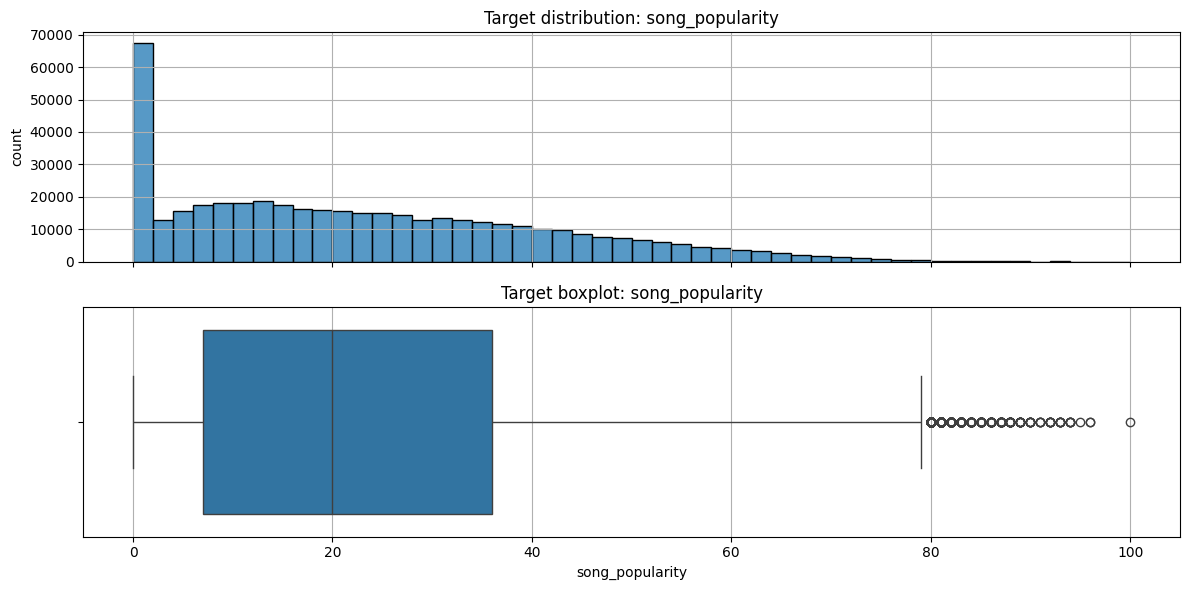

In [29]:
fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

# Histogram
sns.histplot(
    data=data_clean,
    x=target_col,
    bins=50,
    kde=False,
    ax=axes[0]
)
axes[0].set_title("Target distribution: song_popularity")
axes[0].set_ylabel("count")

# Boxplot
sns.boxplot(
    data=data_clean,
    x=target_col,
    ax=axes[1]
)
axes[1].set_title("Target boxplot: song_popularity")
axes[1].set_xlabel(target_col)

plt.tight_layout()
plt.show()

In [30]:
# Concentration check: counts by value (useful since the target is discrete)
pop_counts = data_clean[target_col].value_counts().sort_index()
pop_counts.to_frame("count")

,count
song_popularity,
0,58948
1,8457
2,6970
3,5991
4,5752
...,...
93,6
94,5
95,1


### Notes on target distribution (MVP)

- **Range & validity:** `song_popularity` is fully populated (`n_missing = 0`) and stays within the expected **0–100** interval (`min = 0`, `max = 100`), suggesting no obvious invalid target values in the current cleaned dataset.

- **Shape (highly skewed):** The distribution is strongly right-skewed, with a **very large mass at 0** (58,948 tracks) and steadily decreasing counts as popularity increases. This indicates the dataset is dominated by low-popularity tracks, while highly popular tracks are rare.

- **Discrete / coarse-grained target:** The target has **98 unique values**, confirming it is an integer-like, discretized score rather than a continuous measurement. This is fine for a Cycle 1 regression baseline, but it also leaves room for later reframing (e.g., ordinal modeling or binning) if prediction stability becomes an issue.

- **Extreme values are extremely sparse:** Very high popularity values are almost absent (e.g., 95: 1 record, 96: 2, 100: 1). Models and evaluation should therefore be robust to heavy imbalance in the upper tail; improvements in the high-popularity region may be difficult to learn and to validate reliably with standard metrics alone.


In [31]:
target = data_clean["song_popularity"]

summary_df = pd.DataFrame({
    "value": {
        "zero_rate": float((target == 0).mean()),
        "q25": target.quantile(0.25),
        "median": target.quantile(0.50),
        "q75": target.quantile(0.75),
    }
})

summary_df

,value
zero_rate,0.1340
q25,7.0000
median,20.0000
q75,36.0000


### Additional target notes (zero-inflation & robust baseline metric)

The target `song_popularity` is a bounded discrete score in [0, 100] with a non‑trivial point mass at zero (~13.4%). This structure introduces two practical risks for a Cycle 1 baseline:

1. **Risk of “lazy” predictions near zero.**  
   With many zeros and a strong concentration in the lower tail, a model optimized for average error can achieve a deceptively good MAE by predicting small values for most tracks, under‑serving higher‑popularity cases.

2. **Boundedness + skew tension with standard regression framing.**  
   Classical linear regression is not designed for bounded outcomes and can yield invalid predictions (<0 or >100). Even flexible ML regressors benefit from evaluation strategies that acknowledge the truncated scale.

Regression theory remains useful because it provides the diagnostic lens for assessing whether zeros behave like a separate regime and for motivating **two‑part reasoning**: 
> $ \text{i. model the probability of structural/excess zeros via a logistic component, and  } $  
> $ \text{ii. model the magnitude among positive outcomes via a second component. } $  

This logic appears in zero‑inflated and hurdle models (Mullahy, 1986; Cameron & Trivedi, 2013) and is also discussed in applied form in Fávero et al. (2023), who emphasize the practical importance of distinguishing structural zeros and evaluating whether a single‑equation model is adequate.

For Cycle 1, we adopt a pragmatic stance:
* Use a **single baseline regressor** for simplicity.  
* Adopt **MAE** as the primary metric, given its robustness under skew, and report **segmented MAE** to avoid degenerate solutions that simply predict low values for most samples:
  - MAE on all samples  
  - MAE on zero‑popularity tracks (`y = 0`)  
  - MAE on positive‑popularity tracks (`y > 0`)
  
  This segmentation acts as a guardrail, ensuring that performance is not inflated by the large concentration of low‑popularity tracks.

* Treat explicit two‑part modeling as a **Cycle 2 candidate** if errors concentrate on the positive tail.

Alternative families exist for outcomes with a mass at zero and a continuous positive component. A common pragmatic option is **Tweedie regression** (Compound Poisson–Gamma, 1 < p < 2), implemented in standard ML toolchains (scikit‑learn, XGBoost, LightGBM).  
For bounded fractional outcomes, **beta regression** and **zero/one‑inflated beta models** provide principled alternatives (Cribari‑Neto & Zeileis, 2010; Ospina & Ferrari, 2012). When applied to a discrete 0–100 score, they become approximations but still serve as conceptual anchors for later iterations.

---

**Mullahy, J.** (1986). [Specification and testing of some modified count data models. *Journal of Econometrics, 33*(3), 341–365.](https://doi.org/10.1016/0304-4076(86)90002-3)

**Cameron, A. C., & Trivedi, P. K.** (2013). [*Regression analysis of count data* (2nd ed.). Cambridge University Press.](https://www.cambridge.org/core/books/regression-analysis-of-count-data/2AB83B406C5798030F7C91ECC99B1BE4)

**Fávero, L. P., Belfiore, P., & Souza, R. F.** (2023). [*Data science, analytics and machine learning with R*. Academic Press.](https://www.sciencedirect.com/book/monograph/9780128242711/data-science-analytics-and-machine-learning-with-r)

**scikit-learn Developers.** (2023). [*TweedieRegressor documentation*](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.TweedieRegressor.html")

**LightGBM Developers.** (2023). [*LightGBM documentation: Tweedie objective*](https://lightgbm.readthedocs.io/en/latest/)

**Cribari-Neto, F., & Zeileis, A.** (2010). [Beta regression in R. *Journal of Statistical Software, 34*(2), 1–24. https://www.jstatsoft.org/v34/i02/](https://www.jstatsoft.org/v34/i02/)

**Ospina, R., & Ferrari, S. L. P.** (2012). [A general class of zero-or-one inflated beta regression models. *Computational Statistics & Data Analysis, 56*(6), 1609–1623.](https://doi.org/10.1016/j.csda.2011.10.005)

# 6. Feature Candidates (DIMENSIONS)

This section provides a lightweight scan of the candidate predictors currently available in `data_clean`. The goal is to:
1. validate feature ranges and basic consistency, 
2. quantify a few obvious anomalies, and 
3. capture early signals about relationships with the target without over-investing in exhaustive cleaning during Cycle 1.

## 6.1 - Range Diagnostics and Anomaly Flags

In [32]:
data_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 439865 entries, 0 to 439864
Data columns (total 18 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   song_popularity                  439865 non-null  int16  
 1   album_release_year               439843 non-null  Int16  
 2   acousticness                     439865 non-null  float32
 3   danceability                     439865 non-null  float32
 4   duration_ms                      439865 non-null  float32
 5   energy                           439865 non-null  float32
 6   instrumentalness                 439865 non-null  float32
 7   key                              439865 non-null  int8   
 8   liveness                         439865 non-null  float32
 9   loudness                         439865 non-null  float32
 10  mode                             439865 non-null  int8   
 11  song_explicit                    439865 non-null  bool   
 12  sp

In [33]:
data_clean.describe().T[['min','max']]

,min,max
song_popularity,0.0000,100.0000
album_release_year,"1,905.0000","2,021.0000"
acousticness,0.0000,0.9960
danceability,0.0000,0.9940
duration_ms,"1,864.0000","6,024,647.0000"
energy,0.0000,1.0000
instrumentalness,0.0000,1.0000
key,0.0000,11.0000
liveness,0.0000,1.0000
loudness,-60.0000,5.2850


Most bounded “audio features” remain within their expected [0, 1] range (`acousticness`, `danceability`, `energy`, `instrumentalness`, `liveness`, `speechiness`, `valence`). A few variables, however, exhibit sentinel-like or long-tail behaviors that are worth monitoring:

- **tempo** spans from **0 to ~250 BPM**; the presence of zeros suggests malformed or missing tempo values encoded as 0.
- **loudness** ranges from **–60 dB to +5.3 dB**; positive values are uncommon and will be monitored as potential edge cases.
- **duration_ms** shows a strong long tail (up to ~100 minutes), indicating a small amount of very long content (e.g., mixes, long live sets, ambient, spoken-word).
- **time_signature** includes 0 for some records, which is likely invalid (or a placeholder) and should be treated as an anomaly flag for later cycles.
- **album_release_year** includes rare implausible values (e.g., far pre-1900); these cases are already tracked via `release_year_missing_or_suspect`.

This scan confirms that the dataset is broadly coherent for Cycle 1 modeling, while highlighting a small set of edge cases that may require targeted handling in later iterations.


## 6.2 - Quantifying a few anomalies

We quantify a handful of anomalies to ensure they are limited in scale and do not block MVP modeling. These records are kept for now (unless explicitly removed later), but flagged for potential refinement in Cycle 2+ if they prove harmful.

In [34]:
tempo_zero = data_clean.query("tempo == 0").shape[0]
loudness_pos = data_clean.query("loudness > 0").shape[0]
duration_long = (data_clean['duration_ms'] > 20*60*1000).sum()
invalid_time_signature = data_clean.query("time_signature == 0").shape[0]

tempo_zero, loudness_pos, duration_long, invalid_time_signature

(968, 440, np.int64(552), 975)

In [35]:
data_raw[(data_raw['duration_ms'] > 20*60*1000)][['song_name', 'artist_name', 'song_popularity', 'album_release_date', 'duration_ms']].sample(10)

,song_name,artist_name,song_popularity,album_release_date,duration_ms
81562,50rry - Gamers Mix,Alan Walker,41,2021-02-12,"3,681,818.0000"
356777,"Symphony in D minor, FWV 48: 1. Lento - Allegro ma non t...",César Franck,4,1987-06-01,"1,241,160.0000"
328481,The Fragrance of Yhvh,Del Hungerford,7,2020-03-02,"1,513,259.0000"
300705,Slinger Kant B: Tiralali / Dich Kins Mich Toch Neet / Ve...,VVG Jocus,10,2016-09-27,"1,365,827.0000"
250329,John Digweed Recorded live at the Bedrock WMC Party at V...,John Digweed,16,2010-07-12,"4,057,195.0000"
195548,FG VII - Continuous DJ Mix,Max Freegrant,23,2018-04-27,"3,032,376.0000"
139364,Surah Al-Qasas,Sheikh Mishary Rashid Alfasay,31,2010-01-01,"1,903,752.0000"
248479,Uykuda Bilinçaltini Temizleme Meditasyonu,Mistik Yol,16,2020-10-27,"1,500,135.0000"
250703,Kapitel 2: Spielregeln,Emily Erdbeer,16,2013-05-24,"1,274,613.0000"
427180,"Wives And Daughters - Chapter 38: Mr. Kirkpatrick, Q.C.",Imagination Audio Books,0,2021-02-15,"1,443,308.0000"


 Check | Condition | Count | Interpretation |
|-------|-----------|--------|----------------|
| **tempo = 0** | `tempo == 0` | 968 | Likely missing or malformed tempo values encoded as zeros.|
| **loudness > 0 dB** | `loudness > 0` | 440 | uncommon values; retained but monitored. |
| **Very long tracks** | `duration_ms > 20 min` | 552 | Long-tail content (ambient, meditation, classical, spoken word, live performance, DJ mix, religious). retained as legitimate but potentially influential outliers. |
| **invalid time signature** | `time_signature == 0` | 975 | likely invalid; should be treated as a special value or filtered/flagged later. |

These anomalies are limited in scale and do not block Cycle 1 modeling.  
They are flagged for later cycles where deeper cleaning or domain-specific handling may be appropriate.

## 6.3 - Univariate distributions (continuous features)

We inspect the shape of key continuous predictors to understand skewness, multimodality, and long tails.

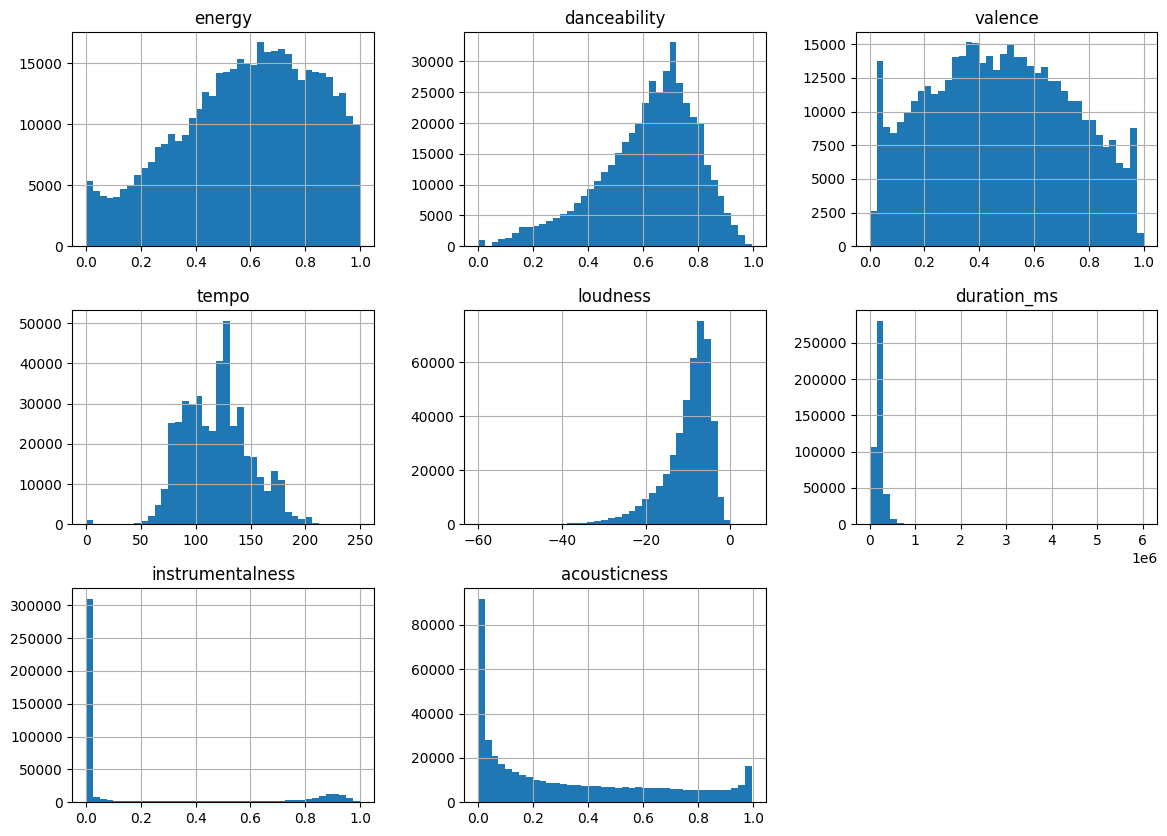

In [36]:
cols = [
    'energy','danceability','valence','tempo','loudness',
    'duration_ms','instrumentalness','acousticness'
]
data_clean[cols].hist(figsize=(14,10), bins=40);

The continuous predictors show distribution shapes typical of large heterogeneous catalogs:

| Feature | Distribution shape | Reproducible insight |
|---------|--------------------|-----------------------|
| **energy** | Right‑skewed toward higher values | Most tracks cluster between ~0.6–0.9 |
| **danceability** | Right‑skewed | High-density region around ~0.6–0.8 |
| **valence** | Broad / weakly bimodal | Mild peaks around low and mid values |
| **tempo** | Centered around ~120–130 BPM | Clear spike at 0 (malformed entries) |
| **loudness** | Left‑skewed | Most tracks between –30 and 0 dB |
| **duration_ms** | Strong long tail | Majority under ~1M ms; few extreme outliers |
| **instrumentalness** | Strongly bimodal | Many tracks near 0; secondary peak near 1 |
| **acousticness** | Bimodal | Peaks near 0 and near 1 |

These shapes suggest that, for Cycle 1, standard scaling is optional (especially for tree-based baselines), but robust evaluation and outlier-awareness remain important.

## 6.4 - Discrete feature distributions

We inspect the distribution of low-cardinality musical features to confirm coverage and spot potential anomalies.

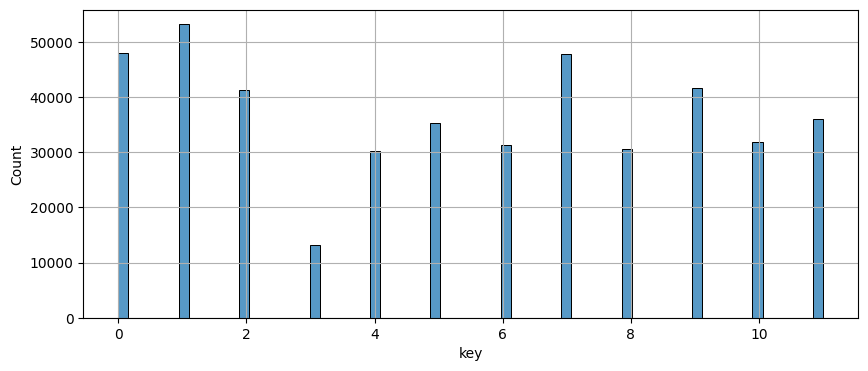

In [37]:
sns.histplot(data=data_clean, x="key");

In [38]:
data_clean['mode'].value_counts()

mode
1    252636
0    187229
Name: count, dtype: int64

time_signature
4    372340
3     44129
5     15467
1      6954
0       975
Name: count, dtype: int64


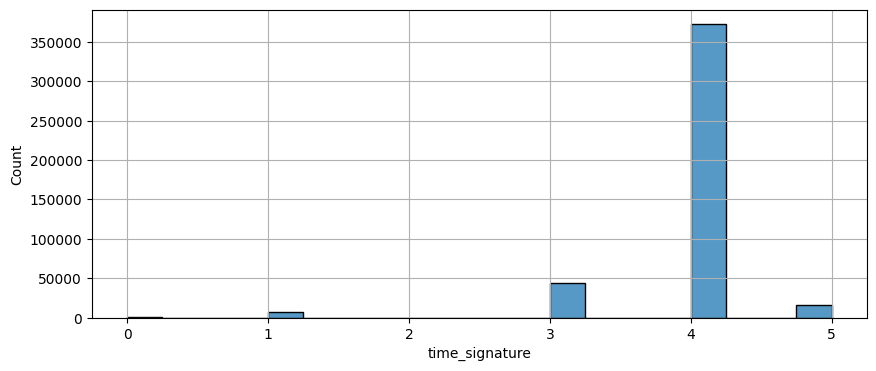

In [39]:
print(f'{data_clean["time_signature"].value_counts()}')
sns.histplot(data=data_clean, x="time_signature");

| Feature | Value range | Distribution insight |
|---------|-------------|----------------------|
| **key** | 0–11 | All pitch classes present; keys 0 and 1 most frequent |
| **mode** | 0 (minor), 1 (major) | ~57% major, ~43% minor |
| **time_signature** | 0–5 | `time_signature = 4` (4/4) dominates (≈85%)|

Discrete variables (`key`, `mode`, `time_signature`) have low cardinality and are suitable for integer treatment in the MVP. The main exception is `time_signature == 0`, which is likely invalid and should be handled explicitly in later cycles (e.g., as a separate category or excluded).

## 6.5 - Metadata feature: `total_available_markets`

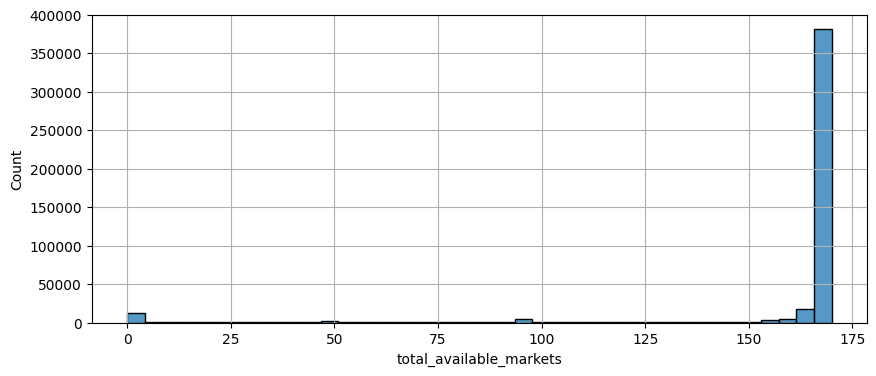

In [40]:
sns.histplot(data_clean['total_available_markets'], bins=40);

In [41]:
data_clean[['total_available_markets','song_popularity']].corr()

,total_available_markets,song_popularity
total_available_markets,1.0000,-0.0156
song_popularity,-0.0156,1.0000


| Aspect | Insight (reproducible) |
|--------|--------------------------|
| **Distribution shape** | Highly skewed toward the upper end, with a strong cluster near ~170 markets |
| **Secondary clusters** | Smaller peaks around ~0, ~50, and ~100 markets |
| **Correlation with popularity** | Very close to zero and slightly negative (≈ −0.016) |
| **Interpretation** | In this sample, broader availability does **not** show a meaningful linear relationship with popularity |

This does not rule out non-linear or interaction effects, but suggests it is not a standalone “more markets → more popularity” signal in Cycle 1.

## 6.6 - Diagnostic flag: `release_year_missing_or_suspect`

This flag was created **[earlier](#sec-44-handling)** by sanitizing `album_release_year` and marking implausible or missing values.

In [42]:
data_clean['release_year_missing_or_suspect'].value_counts()

release_year_missing_or_suspect
False    439843
True         22
Name: count, dtype: int64

<Axes: xlabel='release_year_missing_or_suspect', ylabel='song_popularity'>

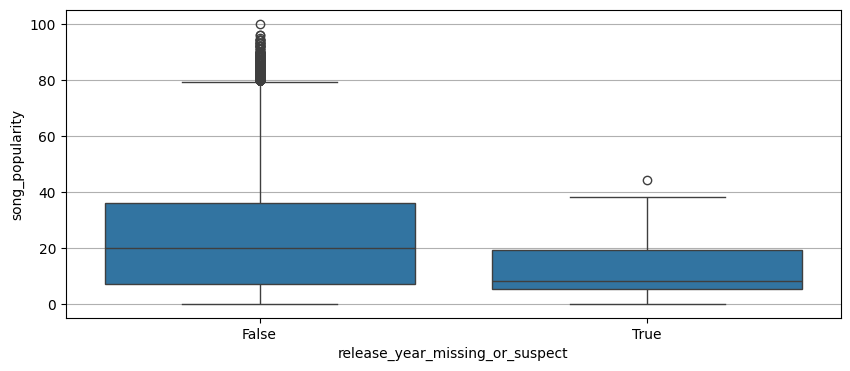

In [43]:
sns.boxplot(data=data_clean, x='release_year_missing_or_suspect', y='song_popularity')

| Aspect | Insight (reproducible) |
|--------|--------------------------|
| **Flag frequency** | Only 19 tracks are flagged as `True` |
| **Popularity distribution** | Flagged tracks show a noticeably lower median popularity |
| **Spread** | Non-flagged tracks show a wider IQR and more high-popularity outliers |
| **Interpretation** | The flag behaves as expected: tracks with implausible or missing years tend to be less popular |

The diagnostic flag is extremely rare, but behaves as expected: flagged records tend to be less popular and have a narrower spread. The feature is kept in the MVP as a quality-control indicator, with the caution that it may capture dataset artifacts rather than musical signal.

## 6.7 - Bivariate relationships with the target

We inspect simple pairwise relationships between key predictors and `song_popularity`.

In [44]:
cols = [
    'energy','danceability','valence','tempo','loudness',
    'duration_ms','instrumentalness','acousticness',
    'total_available_markets'
]

corrs = data_clean[cols + ['song_popularity']].corr()['song_popularity'].sort_values(ascending=False)
corrs

song_popularity            1.0000
loudness                   0.1471
energy                     0.0849
danceability               0.0189
tempo                      0.0051
valence                   -0.0005
total_available_markets   -0.0156
duration_ms               -0.0303
acousticness              -0.0671
instrumentalness          -0.0954
Name: song_popularity, dtype: float64

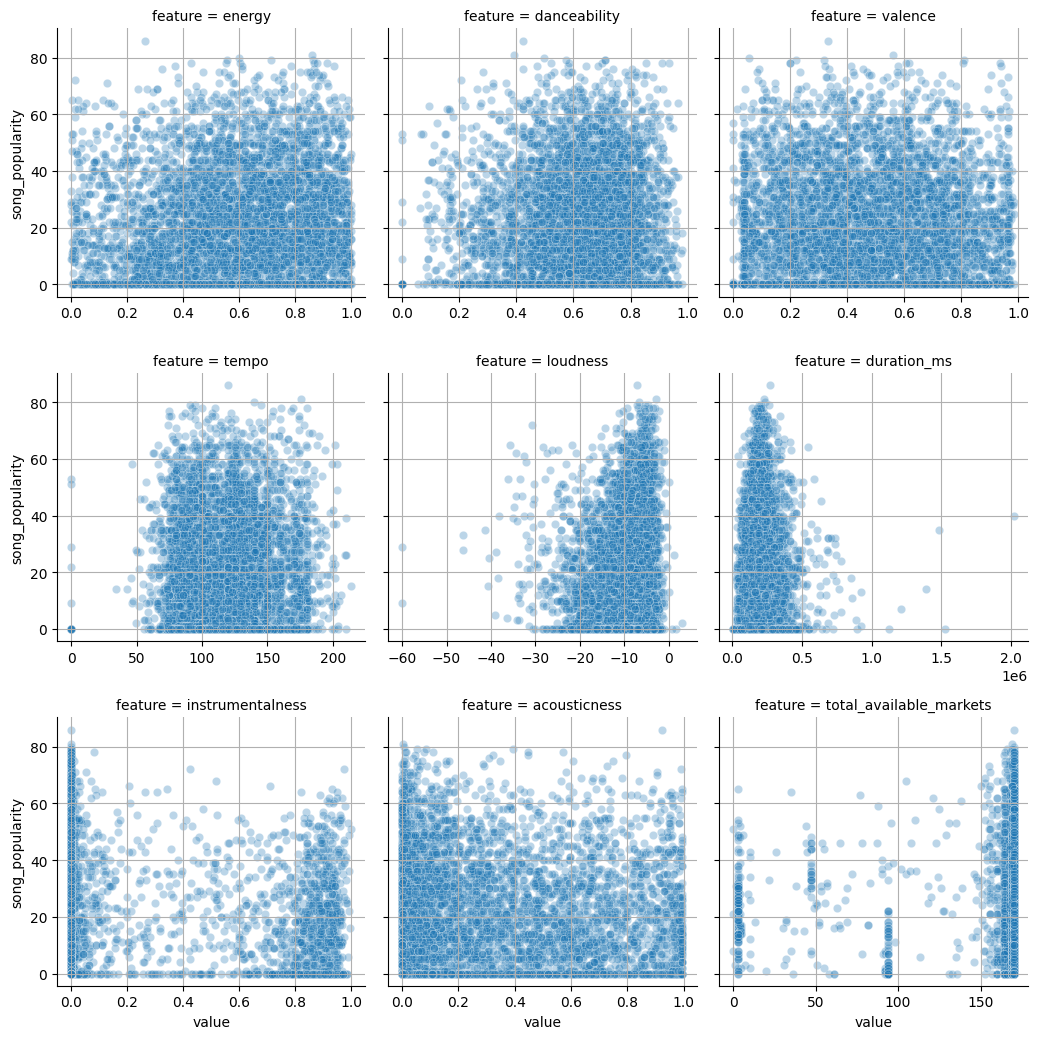

In [45]:
melted = data_clean.sample(5000, random_state=42)[cols + ['song_popularity']].melt(
    id_vars='song_popularity',
    var_name='feature',
    value_name='value'
)

g = sns.FacetGrid(melted, col='feature', col_wrap=3, sharex=False, sharey=True, height=3.5)
g.map(sns.scatterplot, 'value', 'song_popularity', alpha=0.3)

| Feature | Correlation with popularity | Reproducible insight |
|---------|------------------------------|-----------------------|
| **energy** | Weak positive | Slight upward trend in scatterplot |
| **danceability** | Weak positive | Mild clustering of higher popularity at higher values |
| **loudness** | Weak positive | Louder tracks tend to be marginally more popular |
| **valence** | Near zero | No visible linear trend |
| **tempo** | Near zero | Popularity spread uniform across tempo range |
| **duration_ms** | Slight negative | Longer tracks slightly less popular on average |
| **instrumentalness** | Negative | Higher instrumentalness associated with lower popularity |
| **acousticness** | Slight negative | Acoustic-heavy tracks slightly less popular |
| **total_available_markets** | Near zero | No meaningful linear relationship |

Most relationships between audio features and `song_popularity` are weak, which is expected: popularity is influenced by many non-audio factors not present in this dataset. Still, mild monotonic tendencies appear for a subset of predictors (e.g., `energy`, `danceability`, `loudness`), while others remain near-zero in linear correlation (e.g., `tempo`, `valence`).

## 6.8 - Pairwise correlations between predictors

We inspect the correlation structure among the main audio features to identify redundancy and potential multicollinearity.

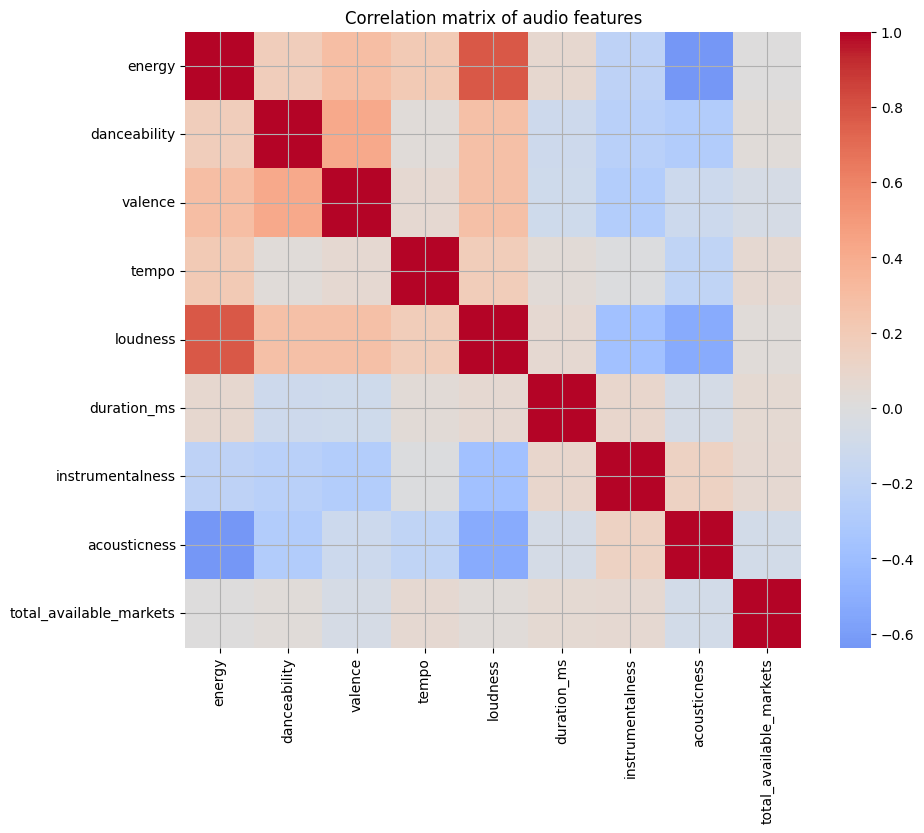

In [46]:
plt.figure(figsize=(10, 8))
sns.heatmap(
    data_clean[cols].corr(),
    cmap='coolwarm',
    center=0,
    annot=False,
    square=True
)
plt.title("Correlation matrix of audio features");

A short list of |corr| ≥ 0.30 highlights intuitive associations (e.g., `energy`–`loudness`, `energy`–`acousticness`, `danceability`–`valence`). Overall, this is a pairwise view and **does not fully characterize multicollinearity**, but it supports retaining the full feature set for the Cycle 1 baseline without dimensionality reduction.

| Feature A | Feature B | Corr | Interpretation |
|-----------|-----------|------|----------------|
| **Energy** | **Loudness** | **0.78** | High‑energy tracks tend to be louder |
| **Energy** | **Acousticness** | **–0.64** | Acoustic tracks are typically less energetic |
| **Loudness** | **Acousticness** | **–0.53** | Acoustic tracks are quieter |
| **Danceability** | **Valence** | **0.41** | Danceable songs tend to be happier |
| **Energy** | **Valence** | **0.29** | Slight tendency for energetic songs to sound “happier” |
| **Valence** | **Instrumentalness** | **–0.28** | Instrumental tracks tend to have lower valence |
| **Danceability** | **Instrumentalness** | **–0.24** | Instrumental tracks are less danceable |

# 7. Leakage & non-usable columns (MVP rules)

Cycle 1 enforces a strict separation between:

- **Predictors available at inference time**, and  
- **Any information that could directly or indirectly reveal the target (`song_popularity`) or contaminate evaluation**.

This section documents which columns are excluded from modeling, why they are excluded, and performs a reproducible audit to ensure that the modeling dataset respects MVP anti‑leakage rules.

## 7.1 - What counts as leakage in this project

We treat the following as leakage risks:

* **Evaluation leakage (preprocessing leakage):** any transformation that learns parameters from the full dataset before splitting (e.g., scaling, imputation, feature selection). This can inflate validation scores and fail in production. The safe rule is: **split first, then fit transforms on train only**, preferably via a pipeline ([Scikit-learn](https://scikit-learn.org/stable/common_pitfalls.html)).
* **Identifier/memorization leakage:** columns that uniquely identify a track (IDs, URLs). Even if they don’t encode the label, they enable memorization and do not generalize.
* **Non-MVP external enrichment:** fields that require API calls or joining external tables at inference time (not acceptable for Cycle 1).

## 7.2 - Columns explicitly excluded from modeling (and why)

The following raw columns are treated as **non-usable** for the MVP:

| Category | Columns | Reason |
|---------|---------|--------|
| **Track identifiers / URLs** | `spotify_id`, `uri`, `track_href`, `analysis_url` | High-cardinality identifiers; enable memorization; not musical content |
| **Text fields** | `song_name`, `artist_name` | Would require NLP or entity resolution; introduces lookup-based leakage risks |
| **Row index artifact** | `Unnamed: 0` | Dataset artifact; not a feature |

These exclusions are deliberate: the Cycle 1 baseline focuses on **audio features + minimal metadata**.

In [47]:
# Sanity check: ensure none of the disallowed columns remain in data_clean
disallowed = {
    "spotify_id", "uri", "track_href", "analysis_url",
    "song_name", "artist_name", "Unnamed: 0"
}

present_disallowed = disallowed.intersection(data_clean.columns)

if present_disallowed:
    print("⚠️ Disallowed columns still present:", present_disallowed)
else:
    print("✓ No disallowed columns found.")

✓ No disallowed columns found.


The check above confirms whether any excluded columns are still present in the modeling dataset.  
If the output shows an empty set (or the ✓ message), the dataset is compliant with the MVP rules.

## 7.3 - Allowed features in Cycle 1

Cycle 1 predictors are limited to:

* **Audio features** (Spotify audio feature space): `acousticness`, `danceability`, `energy`, `instrumentalness`, `liveness`, `speechiness`, `valence`, `loudness`, `tempo`, `duration_ms`, plus discrete descriptors like `key`, `mode`, `time_signature`.
* **Availability proxy:** `total_available_markets` (kept as low-cost metadata).
* **Release timing:** `album_release_year` (kept for temporal context and potential time-aware splitting).
* **Diagnostic flag:** `release_year_missing_or_suspect` (allowed because it is derived only from release-date consistency checks, not from popularity).

## 7.4 - MVP anti-leakage rules (operational)

To keep modeling and evaluation clean:

1. **No global `fit` before splitting.** Any scaler/imputer/selector must be trained on `train` only (use a pipeline) ([Scikit-learn](https://scikit-learn.org/stable/common_pitfalls.html)).
2. **No joins or API enrichment in Cycle 1.** If a feature requires calling Spotify or any external service at inference time, it is out-of-scope for the MVP.
3. **Keep high-cardinality identifiers out of the model.** They are retained only for debugging/auditing, never as predictors.
4. **Document every derived feature.** Each new feature must specify whether it uses only information available at inference time.

These rules govern *how* modeling is performed rather than *what* is in the dataset, so no code is required here. The enforcement happens naturally through the pipeline design in Section 8.

# 8. Baseline Evaluation Plan (no heavy modeling)

This section defines how the Cycle 1 baseline will be evaluated: **task framing**, **data splits**, and **metrics**. 

The goal is to establish a **clean, reproducible, leakage‑free evaluation protocol** without introducing heavy modeling.

---

## 8.1 - Task type

The target `song_popularity` is a **bounded discrete score** in **[0, 100]**.

For Cycle 1 (MVP), we treat this as a **regression task**:

* Predicting a numeric score preserves the full information content (no arbitrary binning).
* Errors remain interpretable in the original units (“popularity points”).

**Decision:** Regression baseline.

---

## 8.2 - Split strategy

Cycle 1 adopts a **Dual Split Strategy** to balance. This is necessary because music metadata often contains **ambiguous release dates** (original vs. remaster vs. digital re‑issue), making a purely temporal split unreliable as the sole evaluation method.

### **A. Primary Benchmark — Random Split (i.i.d.)**

**Purpose:**  
A stable baseline unaffected by release‑year inconsistencies. A shuffled holdout split provides a stable split that does not depend on release-date semantics.

**Protocol:**  
- Test = 20% (held out until the end)  
- Validation = 10%  
- Train = 70%

**Implementation rules (data hygiene):**

* The temporal split uses a **specific integer year** as cutoff (no float quantiles).
* Rows flagged as `release_year_missing_or_suspect` are **excluded from the temporal test set** to reduce noise and avoid spurious conclusions.

In [48]:
x = data_clean.drop(columns=["song_popularity"])
y = data_clean["song_popularity"]

# Step 1: test split (20%)
x_trainval, x_test_r, y_trainval, y_test_r = train_test_split(
    x, y, test_size=0.20, random_state=42, shuffle=True
)

# Step 2: validation split (10% overall → 12.5% of remaining)
x_train_r, x_val_r, y_train_r, y_val_r = train_test_split(
    x_trainval, y_trainval, test_size=0.125, random_state=42, shuffle=True
)

pd.DataFrame({
    "split": ["train", "val", "test"],
    "rows": [len(y_train_r), len(y_val_r), len(y_test_r)],
    "zero_rate": [
        y_train_r.eq(0).mean(),
        y_val_r.eq(0).mean(),
        y_test_r.eq(0).mean(),
    ],
    "median_popularity": [
        y_train_r.median(),
        y_val_r.median(),
        y_test_r.median(),
    ],
})

,split,rows,zero_rate,median_popularity
0,train,307905,0.1338,20.0000
1,val,43987,0.1339,20.0000
2,test,87973,0.1348,20.0000


### **B. Secondary Diagnostic — Temporal Split (Best Effort)**

**Purpose:**  
Probe whether the model generalizes to “nominally newer” tracks. If performance drops substantially relative to the random holdout, it suggests either:
    * a temporal distribution shift (concept drift), or
    * that the year metadata is too noisy to support temporal evaluation reliably.

**Temporal hygiene rules:**

- Use **explicit integer years** (no quantiles).  
- Remove all rows flagged as `release_year_missing_or_suspect` from the **entire temporal experiment** (train/val/test).  
  This avoids timeline contamination and prevents any appearance of cherry‑picking.

**Cycle 1 temporal protocol (based on dataset distribution):**

- **Train:** `album_release_year ≤ 2019`  
- **Validation:** `album_release_year == 2020`  
- **Test:** `album_release_year == 2021`

In [49]:
# Remove suspect years entirely from the temporal experiment
df_temp = data_clean.loc[~data_clean["release_year_missing_or_suspect"]].copy()

train_mask = df_temp["album_release_year"] <= 2019
val_mask   = df_temp["album_release_year"] == 2020
test_mask  = df_temp["album_release_year"] == 2021

x_train_t = df_temp.loc[train_mask].drop(columns=["song_popularity"])
y_train_t = df_temp.loc[train_mask]["song_popularity"]

x_val_t = df_temp.loc[val_mask].drop(columns=["song_popularity"])
y_val_t = df_temp.loc[val_mask]["song_popularity"]

x_test_t = df_temp.loc[test_mask].drop(columns=["song_popularity"])
y_test_t = df_temp.loc[test_mask]["song_popularity"]

pd.DataFrame({
    "split": ["train_t", "val_t", "test_t"],
    "rows": [
        len(y_train_t),
        len(y_val_t),
        len(y_test_t),
    ],
    "zero_rate": [
        y_train_t.eq(0).mean(),
        y_val_t.eq(0).mean(),
        y_test_t.eq(0).mean(),
    ],
    "median_popularity": [
        y_train_t.median(),
        y_val_t.median(),
        y_test_t.median(),
    ],
    "min_year": [
        df_temp.loc[train_mask, "album_release_year"].min(),
        df_temp.loc[val_mask,   "album_release_year"].min(),
        df_temp.loc[test_mask,  "album_release_year"].min(),
    ],
    "max_year": [
        df_temp.loc[train_mask, "album_release_year"].max(),
        df_temp.loc[val_mask,   "album_release_year"].max(),
        df_temp.loc[test_mask,  "album_release_year"].max(),
    ],
})

,split,rows,zero_rate,median_popularity,min_year,max_year
0,train_t,283466,0.1162,21.0000,1905,2019
1,val_t,105605,0.1317,20.0000,2020,2020
2,test_t,50772,0.2387,14.0000,2021,2021


**Decision:** Dual split (Random as primary, Temporal as diagnostic).

## 8.3 Metrics

All metrics are reported in **popularity points**.

### **Primary metric**
- **MAE** — robust under skew; directly interpretable as “average error in points”.

### **Secondary metrics**
- **RMSE** — highlights large errors (useful to detect occasional severe errors.  
- **R²** — context only (bounded/skewed targets can distort interpretation, reported only as a reference statistic).

### **Segment‑Aware Diagnostics (Zero Inflation)**

Because the target has a **non-trivial mass at zero** (~13.4%), we also report:

- MAE on `y == 0`  
- MAE on `y > 0`  

This prevents a baseline from appearing “good” by predicting near-zero values for most tracks.

**Decision:** *MAE + segmented MAE* (zeros vs positives), with RMSE and R² as complements.

In [50]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

def regression_metrics(y_true, y_pred):
    return {
        "mae":  mean_absolute_error(y_true, y_pred),
        "rmse": np.sqrt(mean_squared_error(y_true, y_pred)),
        "r2":   r2_score(y_true, y_pred),
    }

def segmented_mae(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)

    zero_mask = y_true == 0
    pos_mask  = y_true > 0

    return {
        "mae_zero": mean_absolute_error(y_true[zero_mask], y_pred[zero_mask]) if zero_mask.any() else np.nan,
        "mae_pos":  mean_absolute_error(y_true[pos_mask],  y_pred[pos_mask])  if pos_mask.any()  else np.nan,
    }

# Baseline: median predictor for each split

# Random split baseline
y_pred_r = np.full_like(y_test_r, y_train_r.median())

# Temporal split baseline
y_pred_t = np.full_like(y_test_t, y_train_t.median())

# Metrics
metrics_random = {
    **regression_metrics(y_test_r, y_pred_r),
    **segmented_mae(y_test_r, y_pred_r),
}

metrics_temporal = {
    **regression_metrics(y_test_t, y_pred_t),
    **segmented_mae(y_test_t, y_pred_t),
}

pd.DataFrame([
    {"split": "random", **metrics_random},
    {"split": "temporal", **metrics_temporal},
])

,split,mae,rmse,r2,mae_zero,mae_pos
0,random,15.2089,18.6763,-0.0220,20.0000,14.4623
1,temporal,15.8386,18.4789,-0.0135,21.0000,14.2203


## 8.4 - Leakage Prevention Rule

To enforce the principles defined in Section 7:

- All preprocessing (scaling, imputation, encoding) must be **fitted on the training split only**.  
- Validation and test sets must be transformed using the **same fitted pipeline**.  
- No statistics from validation/test may influence training.

This ensures the baseline is **leakage‑free** and reproducible.

## 8.5 Baseline Interpretation (Random vs Temporal)

- **MAE:** slightly higher on the temporal split, consistent with the larger share of zero‑popularity tracks in 2021.  
- **RMSE:** slightly lower on the temporal split, reflecting fewer extreme values among recent releases.  
- **R²:** negative for both splits, as expected from a constant baseline.  
- **Segmented MAE:**  
  - **MAE_zero** is high because a constant predictor performs poorly on zero‑popularity tracks.  
  - **MAE_pos** is lower, indicating that positive‑popularity tracks are closer to the median baseline.

The baseline behaves as expected:  
- the random split provides a stable i.i.d. reference  
- the temporal split shows mild distribution shift and higher zero‑inflation  
- no signs of leakage or anomalies  
- the evaluation protocol is validated for Cycle 1 modeling

# 9. Decisions & Next Steps (Compact Edition)

This notebook establishes the **Cycle 1 EDA and evaluation protocol**.  
All methodological decisions for the MVP are now finalized.

---

## 9.1 - Final MVP Decisions

- **Task type:** Regression on a bounded discrete target (`song_popularity ∈ [0,100]`).  
- **Evaluation protocol:**  
  - **Random split (primary)** — i.i.d. benchmark.  
  - **Temporal split (diagnostic)** — generalization to newer releases.  
- **Temporal hygiene:**  
  - Rows with `release_year_missing_or_suspect = True` are excluded from the entire temporal experiment.  
  - Temporal boundaries: **Train ≤ 2019**, **Val = 2020**, **Test = 2021**.  
- **Metrics:** MAE (primary), RMSE and R² (secondary), plus segment‑aware MAE (`y==0`, `y>0`).  
- **Leakage prevention:** All preprocessing is fit on **train only** and applied to val/test via the same pipeline.

---

## 9.2 - Next Steps (Cycle 1)

These steps belong to the **next notebook**, not this one:

- Implement preprocessing inside a scikit‑learn `Pipeline`.  
- Train and evaluate the **median baseline** on both splits.  
- Produce the consolidated metrics table (random vs temporal).  
- Begin Cycle 1 error analysis (zero vs positive segments).

---

## **9.3 - Transition to Cycle 1**

With the EDA complete and the evaluation protocol validated, the project is ready to move to the **Cycle 1 baseline training notebook**, where modeling and diagnostics will begin.



In [51]:
# .to_json(indent=2)